In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.optimizers import LMSolver,LMProblem
import jax
from jsindy.optim.solvers.lm_solver import CholeskyLM, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import AlternatingActiveSolve
from jsindy.trajectory_model import TrajectoryModel
from jax.scipy.linalg import block_diag
import jax.numpy as jnp
from jsindy.util import full_data_initialize
from dataclasses import dataclass

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from jsindy.kernels import ConstantKernel,ScalarMaternKernel
exp_data = LorenzExp

## Sheeeesh switching to the cholesky reparametrization fixed it

In [2]:
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = 8.
dt = 0.12
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)
kernel = (
        ConstantKernel(variance = 5.)
        +ScalarMaternKernel(p = 5,variance = 10.)
    )   
trajectory_model = CholDataAdaptedRKHSInterpolant(kernel = kernel)#,nugget = 1e-8)
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 2000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-14,
    init_alpha = 5.,
    max_line_search_iterations=100,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=AlternatingActiveSetLMSolver(beta_reg=0.001,
                        solver_settings=optsettings,
                        fixed_colloc_weight=50.),
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(8.65377059, dtype=float64), 'data_weight': Array(0.11554321, dtype=float64), 'colloc_weight': 50.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 5.461e+06, gradnorm = 1.412e+07, alpha = 5.0, improvement_ratio = 0.7662
Iteration 1, loss = 2.75e+06, gradnorm = 1.198e+08, alpha = 5.0, improvement_ratio = 0.4964
Iteration 2, loss = 7.667e+05, gradnorm = 8.98e+07, alpha = 5.0, improvement_ratio = 0.7213
Iteration 3, loss = 6.944e+05, gradnorm = 9.575e+07, alpha = 30.38, improvement_ratio = 0.09426
Iteration 4, loss = 1.115e+04, gradnorm = 7.269e+07, alpha = 25.31, improvement_ratio = 0.9842
Iteration 5, loss = 451.9, gradnorm = 7.43e+06, alpha = 21.09, improvement_ratio = 0.9734
Iteration 200, loss = 94.05, gradnorm = 2.929e+03, alpha = 0.06428, improvement_ratio = 0.7662
Iteration 319, loss = 93.53, gradnorm = 0.007063, alpha = 62.79, improvement_ratio = inf
Model after smooth warm start
(x)' = 0.170 1 + 12.923 x + -2.516 y + -1.743 z + -0.990 x^2 + 0.633 x y + -0.695 x z + 0.070 y^2 + 0.369 y z + 0.087 z^2
(y)' = 29.048 1 + 18.827 x + 3.966 y + -4.158 z + -3.940 x^2 + 5.284 x y + -0.514 x z + -1.782 y^2 + -0.31

In [3]:
model.print()

(x)' = -11.922 x + 11.841 y
(y)' = 25.854 x + -0.570 y + -0.937 x z
(z)' = -2.676 z + 0.995 x y


0.005895699906878596


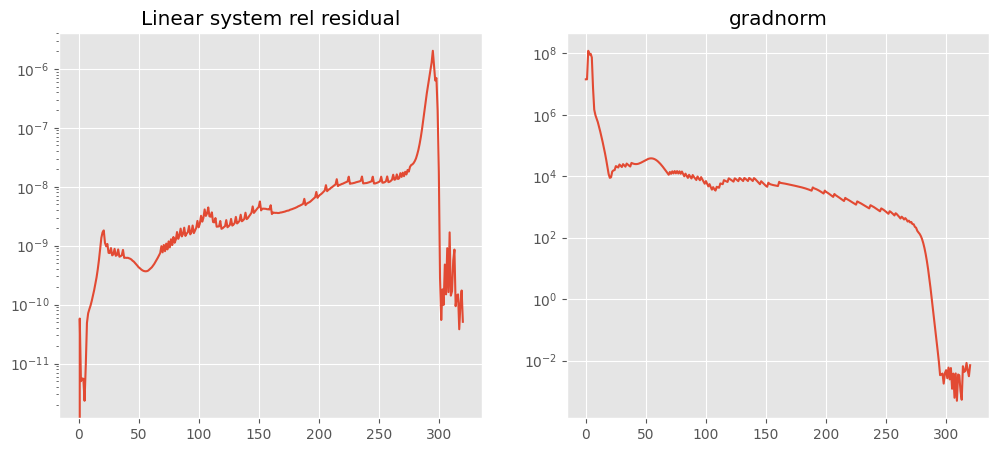

In [5]:
opt = model.opt_result[0]
metrics = {}
metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)
metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
print(metrics['data_mets']['normalized_mse'])
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(opt.linear_system_rel_residual)
plt.title("Linear system rel residual")
plt.yscale('log')
plt.subplot(1,2,2)
plt.title("gradnorm")
plt.plot(opt.gradnorm)
plt.yscale('log')
plt.show()

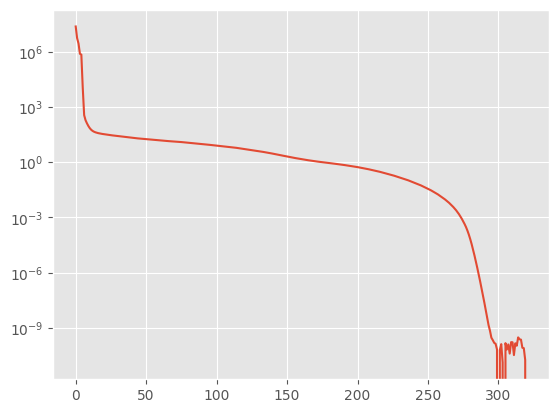

In [6]:
plt.plot(opt.loss_vals - opt.loss_vals[-1])
plt.yscale('log')

In [7]:
metrics = {}
metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)
metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics

{'coeff_mets': {'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'coeff_rel_l2': 0.10931884947903202,
  'coeff_rmse': 0.6292915337096923,
  'coeff_mae': 0.2139167823724472},
 'data_mets': {'mse': Array(22.93630622, dtype=float64),
  'rmse': np.float64(4.7891863835967055),
  'mae': np.float64(2.954693580676532),
  'max_abs_error': np.float64(25.693147570255803),
  'normalized_mse': Array(0.0058957, dtype=float64),
  'relative_l2_error': np.float64(0.07677121958337452)}}

In [8]:
model.print()

(x)' = -11.922 x + 11.841 y
(y)' = 25.854 x + -0.570 y + -0.937 x z
(z)' = -2.676 z + 0.995 x y


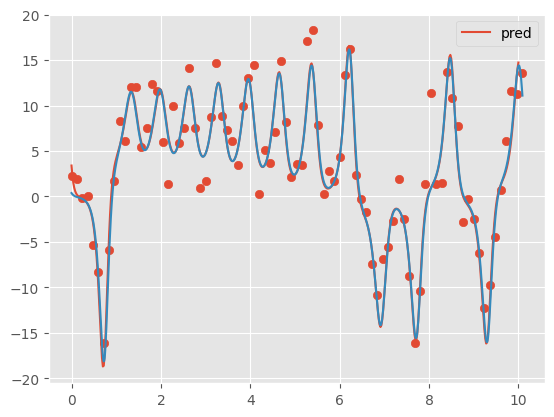

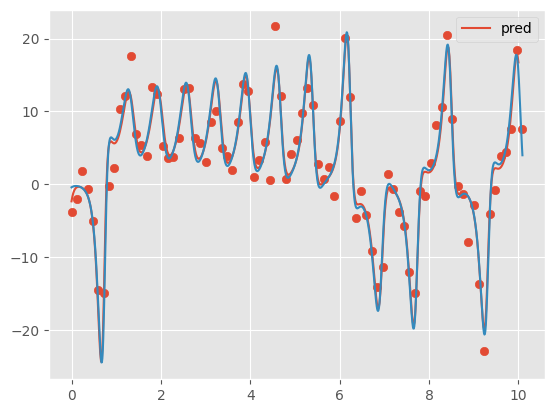

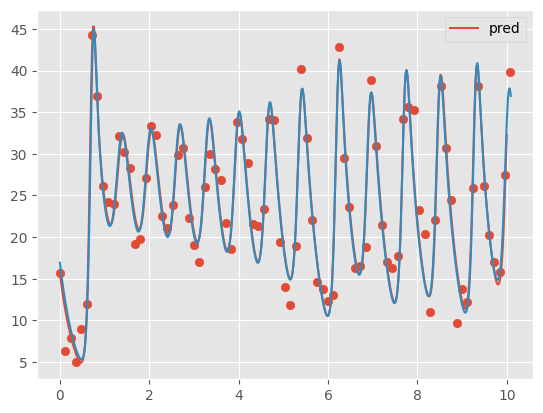

In [9]:
t_grid = jnp.linspace(0,10,500)
x_pred = model.predict_state(t_grid)

for i in range(3):
    plt.scatter(expdata.t_train,expdata.x_train[:,i])
    plt.plot(t_grid,x_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_true[:,i])
    plt.legend()
    plt.show()

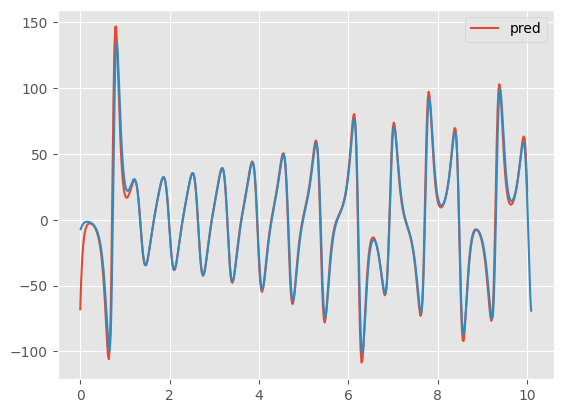

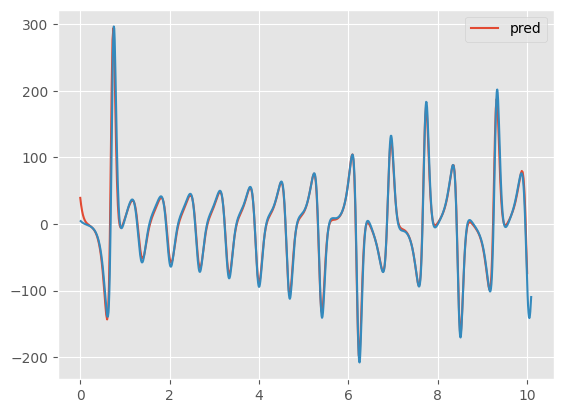

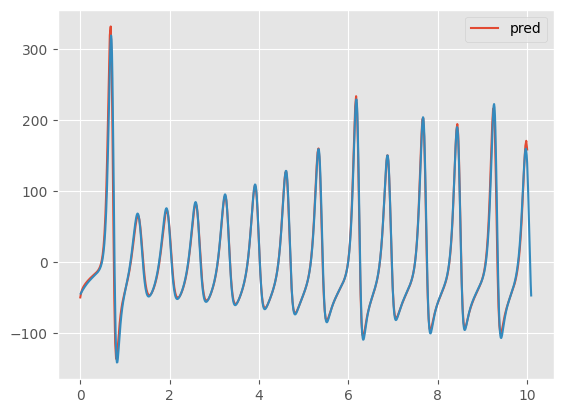

In [10]:
t_grid = jnp.linspace(0,10,500)
xdot_pred = model.traj_model.derivative(t_grid,model.z)

h = expdata.t_true[1]-expdata.t_true[0]
for i in range(3):
    plt.plot(t_grid,xdot_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true[1:],jnp.diff(expdata.x_true[:,i])/h)
    plt.legend()
    plt.show()

In [11]:
t_grid = jnp.linspace(0,10,2000)

xdot_pred = model.traj_model.derivative(t_grid,model.z)
x_pred = model.predict_state(t_grid)
A = dynamics_model.feature_map(x_pred)

I = jnp.eye(A.shape[1])
refit_theta = jnp.linalg.solve(A.T@A + 0.1*I ,A.T@xdot_pred)

from pysindy import STLSQ,SR3,EnsembleOptimizer
stlsq = STLSQ(threshold = 0.25,alpha =0.01,unbias = True)
optimizer = stlsq#EnsembleOptimizer(stlsq,library_ensemble=True,bagging = True,n_subset = 100)
optimizer.fit(A,xdot_pred)
refit_theta = jnp.array(optimizer.coef_).T

model.print(refit_theta)

(x)' = -11.922 x + 11.841 y
(y)' = 25.854 x + -0.570 y + -0.937 x z
(z)' = -2.676 z + 0.995 x y


In [12]:
jnp.mean((dynamics_model.predict(expdata.x_test,refit_theta) - expdata.x_dot_test)**2)/jnp.var(expdata.x_dot_test)

Array(0.00597469, dtype=float64)

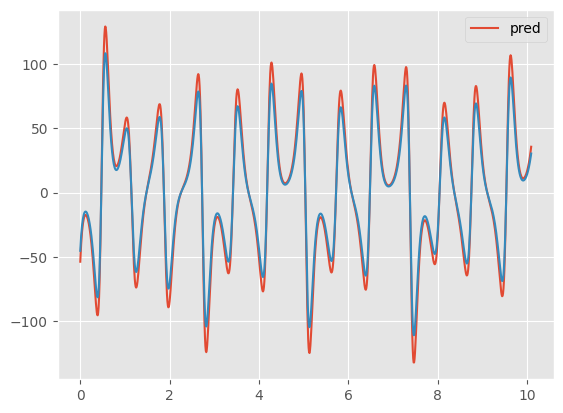

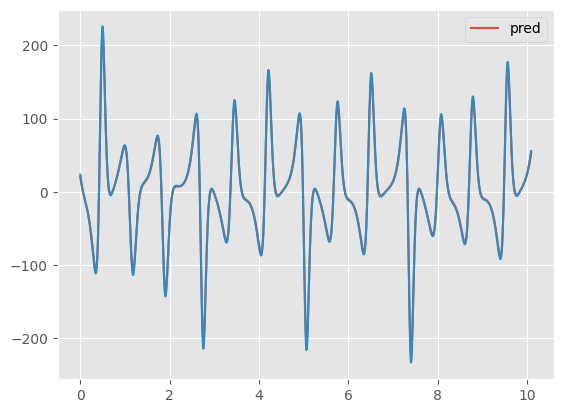

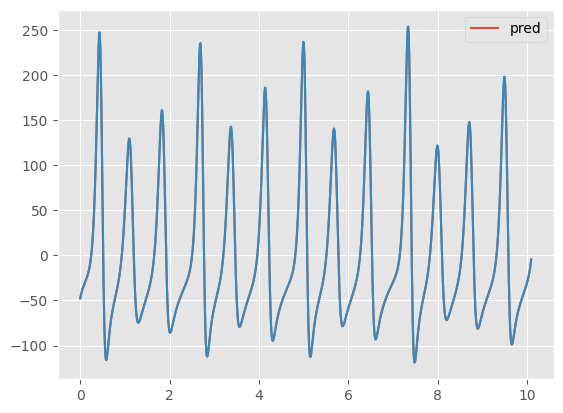

In [13]:
test_pred = dynamics_model.predict(expdata.x_test,refit_theta)
for i in range(3):
    plt.plot(expdata.t_true,test_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_dot_test[:,i])
    plt.legend()
    plt.show()